In [1]:
import numpy as np 
import pandas as pd
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from sklearn.model_selection import train_test_split
import albumentations as alb
import cv2


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install pydicom
import pydicom  as pdcm

     |████████████████████████████████| 2.0 MB 4.3 MB/s 


In [4]:
project_path = "/content/drive/My Drive/"

In [43]:
from zipfile import ZipFile

with ZipFile('/content/drive/My Drive/rsna-pneumonia-detection-challenge.zip', 'r') as zipdata:
    data = zipdata.open('stage_2_train_labels.csv')

In [6]:
import pandas as pd

df = pd.read_csv(data)

In [7]:
print('First five rows of Training set:\n', df.head())
print(df.iloc[0])

First five rows of Training set:
                               patientId      x      y  width  height  Target
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN       0
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN       0
2  00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN       0
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN       0
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1
patientId    0004cfab-14fd-4e49-80ba-63a80b6bddd6
x                                             NaN
y                                             NaN
width                                         NaN
height                                        NaN
Target                                          0
Name: 0, dtype: object


In [8]:
df.columns

Index(['patientId', 'x', 'y', 'width', 'height', 'Target'], dtype='object')

In [9]:
df.isnull().sum()

patientId        0
x            20672
y            20672
width        20672
height       20672
Target           0
dtype: int64

In [10]:
df.shape[0]

30227

In [11]:
df.shape[1]

6

In [12]:
# Number of duplicates in patientId:
print('Number of unique patientId are: {}'.format(df['patientId'].nunique()))

Number of unique patientId are: 26684


In [48]:
clean_df = df.drop_duplicates('patientId')

In [49]:
clean_df.shape[0]

26684

## Distribution of Patients with and without Pneumonia

#### Patients with Pneumonia

In [15]:
## Patients without Pneumonia
wtPnm = df[df.Target == 1]
wtPnm 

,patientId,x,y,width,height,Target
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1
8,00704310-78a8-4b38-8475-49f4573b2dbb,323.0,577.0,160.0,104.0,1
14,00aecb01-a116-45a2-956c-08d2fa55433f,288.0,322.0,94.0,135.0,1
16,00c0b293-48e7-4e16-ac76-9269ba535a62,306.0,544.0,168.0,244.0,1
19,00f08de1-517e-4652-a04f-d1dc9ee48593,181.0,184.0,206.0,506.0,1
...,...,...,...,...,...,...
30208,c18d1138-ba74-4af5-af21-bdd4d2c96bb5,646.0,386.0,141.0,206.0,1
30214,c1cddf32-b957-4753-acaa-472ab1447e86,269.0,416.0,193.0,285.0,1
30219,c1e73a4e-7afe-4ec5-8af6-ce8315d7a2f2,666.0,418.0,186.0,223.0,1
30221,c1ec14ff-f6d7-4b38-b0cb-fe07041cbdc8,609.0,464.0,240.0,284.0,1


#### Patients without Pneumonia

In [16]:
## Patients without Pneumonia
WtoPnm = df[df.Target == 0]
WtoPnm

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
6,00569f44-917d-4c86-a842-81832af98c30,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...
30216,c1cf3255-d734-4980-bfe0-967902ad7ed9,NaN,NaN,NaN,NaN,0
30217,c1e228e4-b7b4-432b-a735-36c48fdb806f,NaN,NaN,NaN,NaN,0
30218,c1e3eb82-c55a-471f-a57f-fe1a823469da,NaN,NaN,NaN,NaN,0
30223,c1edf42b-5958-47ff-a1e7-4f23d99583ba,NaN,NaN,NaN,NaN,0


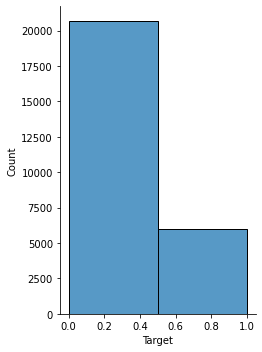

In [26]:
# Distribution of Pnemonia among the patients
dp_Pnem_cnt = sns.displot(df.Target, bins=2, height=5, aspect=0.75)

In [17]:
print(f'Percentage of Patients with Pneumonia :  {round(wtPnm.shape[0]/df.shape[0]*100, 0)}% ')
print(f'Percentage of Patients without Pneumonia  {round(WtoPnm.shape[0]/df.shape[0]*100, 0)}%')

Percentage of Patients with Pneumonia :  23.0% 
Percentage of Patients without Pneumonia  77.0%


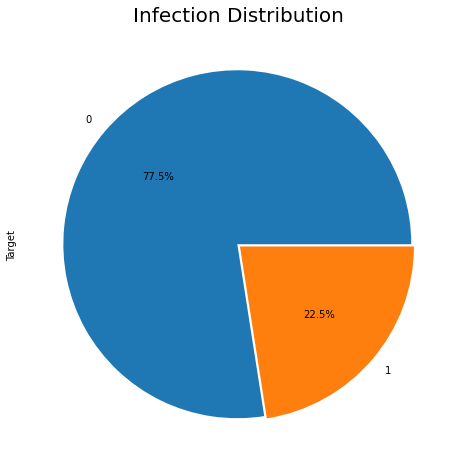

In [31]:
fig = plt.figure(figsize =(8,8))
ax1 = fig.add_subplot(111)
ax1.title.set_text("Infection Distribution")
ax1.title.set_fontsize(20)

dp_inf = df.Target.value_counts()

dp_inf.plot.pie(autopct="%1.1f%%", ax=ax1, explode=[0.01,0.01])

plt.show()

### Identify Bounding Box 

In [39]:
# Checking nulls in bounding box columns:
print('Number of nulls in bounding box columns: {}'.format(df[['x', 'y', 'width', 'height']].isnull().sum().to_dict()))

Number of nulls in bounding box columns: {'x': 20672, 'y': 20672, 'width': 20672, 'height': 20672}


In [51]:
Bbox = df.groupby('patientId').size().to_frame('Boxes').reset_index()
df = df.merge(Bbox, on = 'patientId', how = 'left')
(Bbox.groupby('Boxes').size().to_frame('Patient Count').reset_index().set_index('Boxes').sort_values(by = 'Boxes'))

,Patient Count
Boxes,
1,23286
2,3266
3,119
4,13


#### Loading Detailed Class

In [59]:
from zipfile import ZipFile

with ZipFile('/content/drive/My Drive/rsna-pneumonia-detection-challenge.zip', 'r') as zipdata:
    data_det = zipdata.open('stage_2_detailed_class_info.csv')

In [60]:
det_class_df = pd.read_csv(data_det)
det_class_df.head()

,patientId,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity


In [62]:
## Shape of the Class file
(det_class_df.shape[0], det_class_df.shape[1])

(30227, 2)

In [63]:
### COunt of unique patients in class file
det_class_df['patientId'].nunique()

26684

In [64]:
## Check Nulls
det_class_df['class'].isnull().sum()

0

30227 class infos loaded
26684 patient cases


,patientId,class
26023,e87a8a11-b8ae-4373-b78d-d5ec6f69724e,No Lung Opacity / Not Normal
2452,3208e231-f146-41b6-b726-1d4267728342,Lung Opacity
25247,e259f5f6-b9c6-48f3-8bf5-193a3c0dd52e,No Lung Opacity / Not Normal


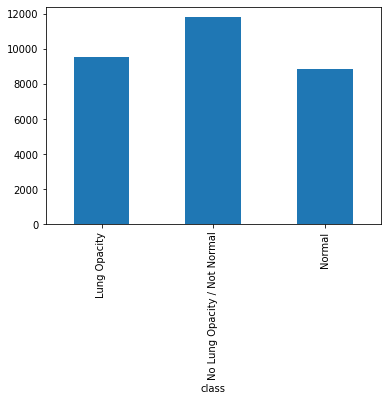

In [54]:
print(det_class_df.shape[0], 'class infos loaded')
print(det_class_df['patientId'].value_counts().shape[0], 'patient cases')
det_class_df.groupby('class').size().plot.bar()
det_class_df.sample(3)

#### Combine Boxes and Labels

In [66]:
print(Bbox.head())
print(det_class_df.head())

                              patientId  Boxes
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6      1
1  000924cf-0f8d-42bd-9158-1af53881a557      1
2  000db696-cf54-4385-b10b-6b16fbb3f985      2
3  000fe35a-2649-43d4-b027-e67796d412e0      2
4  001031d9-f904-4a23-b3e5-2c088acd19c6      2
                              patientId                         class
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6  No Lung Opacity / Not Normal
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd  No Lung Opacity / Not Normal
2  00322d4d-1c29-4943-afc9-b6754be640eb  No Lung Opacity / Not Normal
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5                        Normal
4  00436515-870c-4b36-a041-de91049b9ab4                  Lung Opacity


In [68]:
comb_bbox_df = pd.concat([Bbox, 
                        det_class_df.drop('patientId',1)], 1)
print(comb_bbox_df.shape[0], 'combined cases')
comb_bbox_df.sample(5)

30227 combined cases


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  


,patientId,Boxes,class
22393,db637cd6-e969-46ec-bd38-e03eb835ac8a,1.0,Normal
3901,39cb7f45-d18f-4087-8994-0798f4f79c5a,1.0,Lung Opacity
7419,58569077-a334-4a12-9619-ec8ac9e1c0da,1.0,No Lung Opacity / Not Normal
13687,8ec959f3-27f9-43dc-98d0-dfa7ddf7d9e9,1.0,Normal
10946,763adcfd-4ebf-4d3b-91bd-a7813dc4bb96,1.0,Normal


In [69]:

Merge_df = pd.concat([df, det_class_df['class']], axis = 1)
Merge_df.head()

,patientId,x,y,width,height,Target,number_of_boxes_x,number_of_boxes_y,Boxes_x,Boxes_y,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,1,1,1,1,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,1,1,1,1,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,1,1,1,1,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,1,1,1,1,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,2,1,2,2,Lung Opacity


Text(0.5, 1.0, 'Class and Target for Chest Exams')

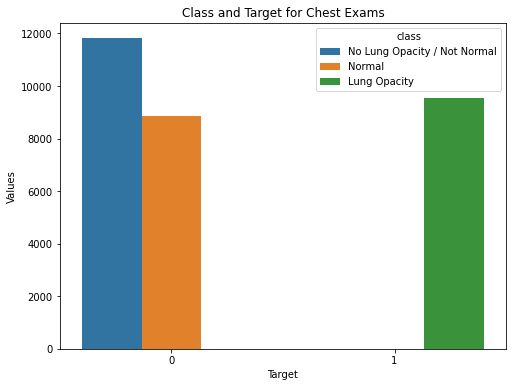

In [73]:
fig, ax = plt.subplots(nrows = 1, figsize = (8, 6))
Disp = Merge_df.groupby('Target')['class'].value_counts()
data_target_class = pd.DataFrame(data = {'Values': Disp.values}, index = Disp.index).reset_index()
sns.barplot(ax = ax, x = 'Target', y = 'Values', hue = 'class', data = data_target_class)
plt.title('Class and Target for Chest Exams')

### Loading the Dicom Data

In [77]:
import zipfile
zf = "/content/drive/My Drive/rsna-pneumonia-detection-challenge.zip"
target_dir = "/content/drive/My Drive/pneumonia_revamped"
zfile = zipfile.ZipFile(zf)
zfile.extractall(target_dir)

In [85]:
train_path = '/content/drive/My Drive/pneumonia_revamped/stage_2_train_images'
test_path = '/content/drive/My Drive/pneumonia_revamped/stage_2_test_images'
#valid_path = '/content/drive/My Drive/pneumonia_revamped/val'

In [86]:
batch_size = 16 
#The dimension of the images we are going to define is 500x500 
img_height = 500
img_width = 500

In [87]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Create Image Data Generator for Train Set
image_gen = ImageDataGenerator(
                                  rescale = 1./255,
                                  shear_range = 0.2,
                                  zoom_range = 0.2,
                                  horizontal_flip = True,          
                               )
# Create Image Data Generator for Test/Validation Set
test_data_gen = ImageDataGenerator(rescale = 1./255)


In [89]:
train = image_gen.flow_from_directory(
      train_path,
      target_size=(img_height, img_width),
      color_mode='grayscale',
      class_mode='binary',
      batch_size=batch_size
      )
test = test_data_gen.flow_from_directory(
      test_path,
      target_size=(img_height, img_width),
      color_mode='grayscale',
      shuffle=False, 
#setting shuffle as False just so we can later compare it with predicted values without having indexing problem 
      class_mode='binary',
      batch_size=batch_size
      )


Found 0 images belonging to 0 classes.
Found 0 images belonging to 0 classes.


In [93]:
Dis_patientId = df['patientId'][0]
dcm_file = '/content/drive/My Drive/pneumonia_revamped/stage_2_train_images/'+'{}.dcm'.format(Dis_patientId)
dcm_data = pdcm.read_file(dcm_file)

print('Metadata of the image consists of \n', dcm_data)

Metadata of the image consists of 
 Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 202
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.276.0.7230010.3.1.4.8323329.28530.1517874485.775526
(0002, 0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.0
(0002, 0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.28530.1517874485.775526
(0008, 0020) Study Date                          DA: '190

In [97]:
import os
print('Count of iamges in training: {}.'.format(len(os.listdir('/content/drive/My Drive/pneumonia_revamped/stage_2_train_images'))))

Count of iamges in training: 26684.


In [100]:
from glob import glob
images = pd.DataFrame({'path': glob(os.path.join(train_path, '*.dcm'))})
images['patientId'] = images['path'].map(lambda x:os.path.splitext(os.path.basename(x))[0])
print('Columns in the training images: {}'.format(list(images.columns)))


Columns in the training images: ['path', 'patientId']


In [101]:
### Merging the Data and Image
Merge_df = Merge_df.merge(images, on = 'patientId', how = 'left')
print('After merging the two dataframe, the training_data has {} rows and {} columns.'.format(Merge_df.shape[0], Merge_df.shape[1]))

After merging the two dataframe, the training_data has 30227 rows and 12 columns.


In [102]:
Merge_df.head()

,patientId,x,y,width,height,Target,number_of_boxes_x,number_of_boxes_y,Boxes_x,Boxes_y,class,path
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,1,1,1,1,No Lung Opacity / Not Normal,/content/drive/My Drive/pneumonia_revamped/sta...
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,1,1,1,1,No Lung Opacity / Not Normal,/content/drive/My Drive/pneumonia_revamped/sta...
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,1,1,1,1,No Lung Opacity / Not Normal,/content/drive/My Drive/pneumonia_revamped/sta...
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,1,1,1,1,Normal,/content/drive/My Drive/pneumonia_revamped/sta...
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,2,1,2,2,Lung Opacity,/content/drive/My Drive/pneumonia_revamped/sta...


#### Plotting Dicom Image Display

In [111]:
def show_dicom_images(data, df, img_path):
  img_data = list(data.T.to_dict().values())
  f, ax = plt.subplots(3, 3, figsize = (16, 18))
  
  for i, row in enumerate(img_data):
    image = row['patientId'] + '.dcm'
    path = os.path.join(img_path, image)
    data = pdcm.read_file(path)
    rows = df[df['patientId'] == row['patientId']]
    #age = rows.PatientAge.unique().tolist()[0]
    #sex = data.PatientSex
    #part = data.BodyPartExamined
    #vp = data.ViewPosition
    #modality = data.Modality
    data_img = pdcm.dcmread(path)
    ax[i//3, i%3].imshow(data_img.pixel_array, cmap = plt.cm.bone)
    ax[i//3, i%3].axis('off')
    box_data = list(rows.T.to_dict().values())
    
    for j, row in enumerate(box_data):
      ax[i//3, i%3].add_patch(Rectangle(xy = (row['x'], row['y']),
                                        width = row['width'], height = row['height'],
                                        color = 'blue', alpha = 0.15))
  plt.show()

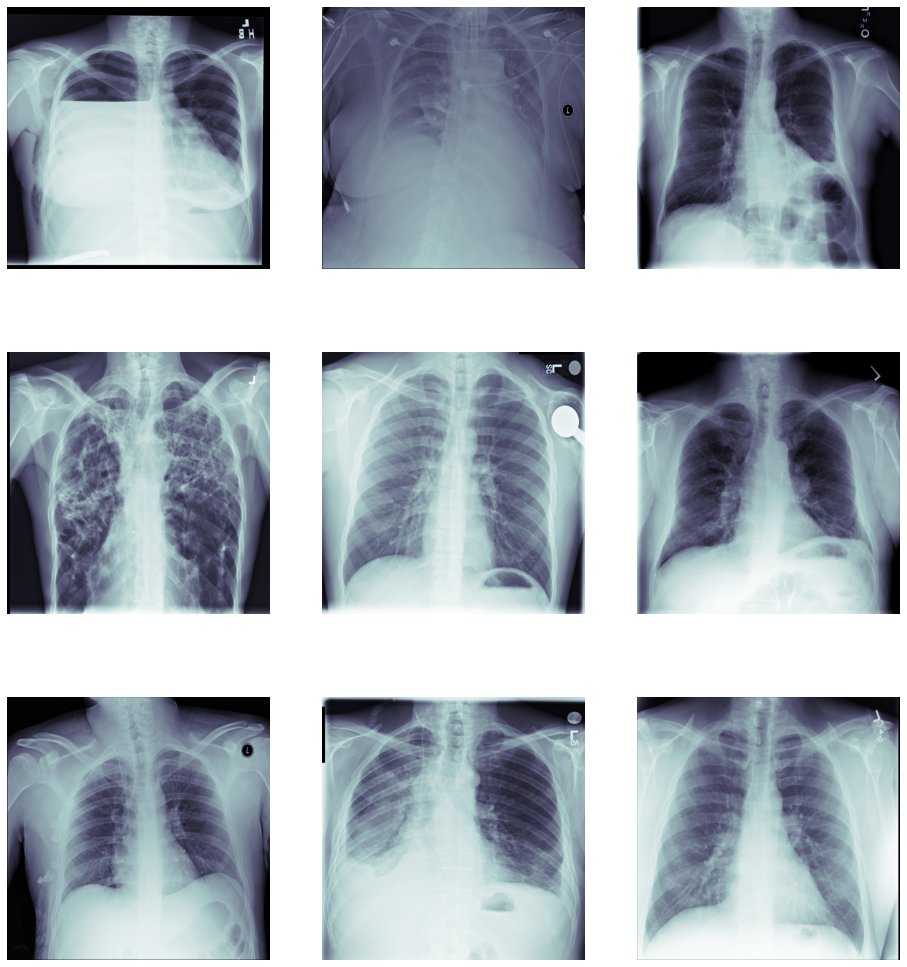

In [113]:
from matplotlib.patches import Rectangle
show_dicom_images(data = Merge_df.loc[(Merge_df['Target'] == 0)].sample(9),
                  df = Merge_df, img_path = '/content/drive/My Drive/pneumonia_revamped/stage_2_train_images/')

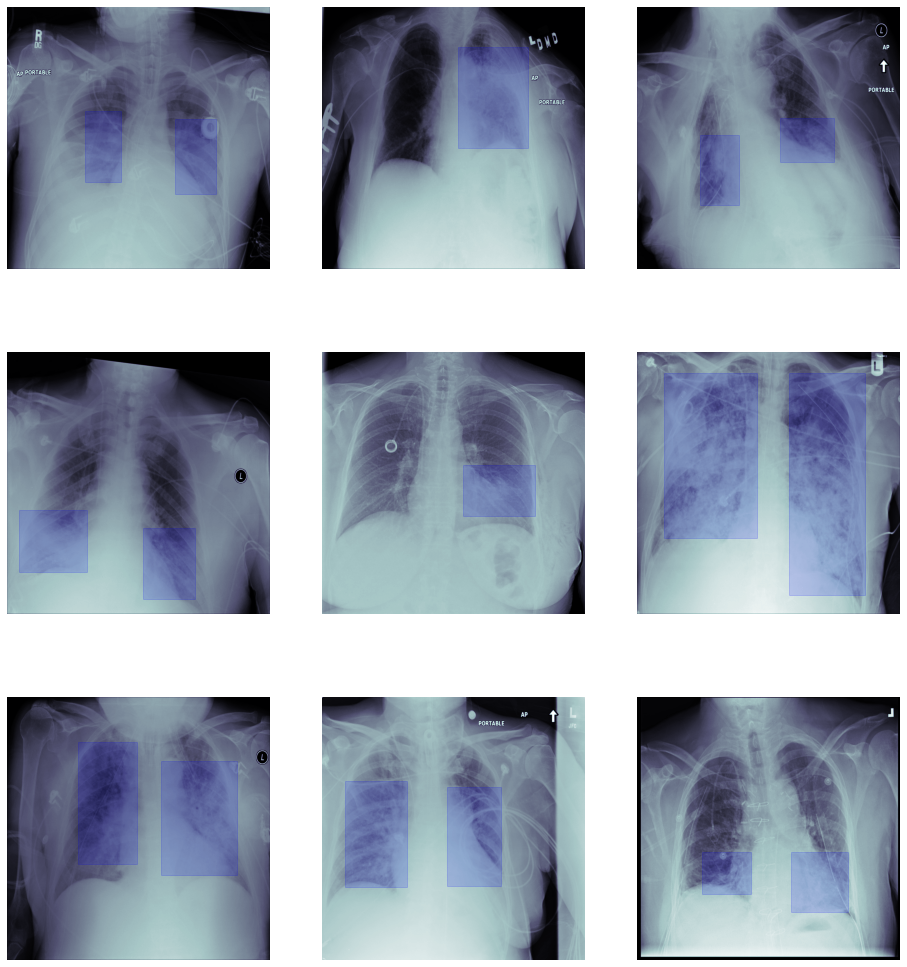

In [114]:
show_dicom_images(data = Merge_df.loc[(Merge_df['Target'] == 1)].sample(9),
                  df = Merge_df, img_path = '/content/drive/My Drive/pneumonia_revamped/stage_2_train_images/')